# **Data Visualization Notebook**

## Objectives

* Answer business requirement 1: 
* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

* Train Dataset
* Validation Dataset
* Test Dataset

## Outputs

* Average images and variability images for each class (healthy or powdery mildew).
* The differences between average healthy and average powdery mildew cherry leaves.
* An image montage for each class.

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between mildew infected leaves and non-infected images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.


## Additional Comments

* No additional comments.



---

# Set Data Directory

---

## Import libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import pandas as pd

sns.set_style("white")

## Set working directory

In [2]:
cwd= os.getcwd()
os.chdir('/workspace/mildew-detection')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/mildew-detection'

## Import dataframes

In [3]:
import pandas as pd

# Paths to the CSV files previously created
train_csv_path = 'train_dataframe.csv'
validation_csv_path = 'validation_dataframe.csv'
test_csv_path = 'test_dataframe.csv'

# Read the CSV files into dataframes
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(validation_csv_path)
test_df = pd.read_csv(test_csv_path)

---

## Set input directories

Set train, validation and test paths using the dataframes

In [4]:
# Define input directories from dataframes
train_path = train_df['file']
validation_path = validation_df['file']
test_path = test_df['file']

## Set output directory

In [6]:
import os

# Define the directory 
work_dir = '/workspace/mildew-detection'

# Find the latest version number
versions = [name for name in os.listdir(os.path.join(work_dir, 'outputs')) if name.startswith('v')]
if versions:
    latest_version = max(versions)
    version_number = int(latest_version[1:]) + 1
else:
    version_number = 1

# Create the new version directory
version = f'v{version_number}'
file_path = os.path.join(work_dir, 'outputs', version)

if not os.path.exists(file_path):
    os.makedirs(file_path)
    print(f'New version {version} created successfully!')
else:
    print('Error: Directory already exists for the new version.')

New version v2 created successfully!


### Set label names

In [11]:
# Extract labels from the train DataFrame
labels = train_df['label'].unique()
print('Labels for the images are:', labels)

Labels for the images are: ['healthy' 'powdery_mildew']


---

# Data visualisation of image data

---

## Image shape 

Compute average images size on train set using OpenCV. https://note.nkmk.me/en/python-opencv-pillow-image-size/

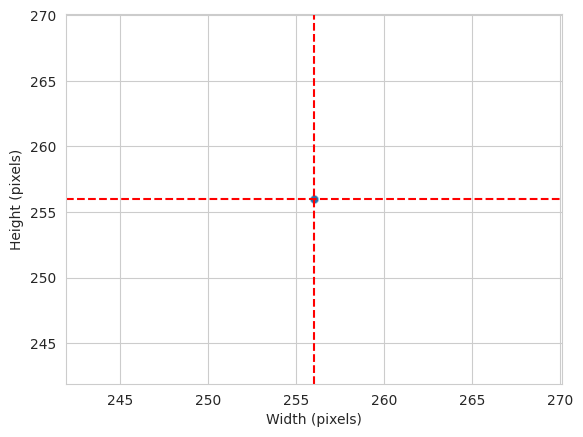

Average shape for images in dataset:
Width average: 256 
Height average: 256


['/workspace/mildew-detection/outputs/v2/image_shape.pkl']

In [12]:
# Initialize lists to store dimensions
dim1, dim2 = [], []

# Iterate through images in the train dataframe
for index, row in train_df.iterrows():
    img = cv2.imread(row['file'])
    if img is not None:
        h, w, _ = img.shape
        dim1.append(h)  # image height
        dim2.append(w)  # image width

# Visualize the distribution of image sizes
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()

# Print and save the average image shape
print("Average shape for images in dataset:")
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")
image_shape = (dim1_mean, dim2_mean, 3)
# Save the image shape embeddings
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

---

## Average and variability of images per label

Function to load images in an array with OpenCV and then resize the images. https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image

In [14]:
def load_image_as_array(dataframe, new_size=(100, 100, 3), n_images_per_label=20):
    X, y = [], []
    
    # Iterate through each row in the dataframe
    for index, row in dataframe.iterrows():
        img_path = row['file']
        label = row['label']
        
        # Load and preprocess the image
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, dsize=new_size[:2], interpolation=cv2.INTER_CUBIC)  # Resize to specified size
        img_array = img_resized.astype(np.float32) / 255.0  # Normalize pixel values

        # Append image and label to X and y lists
        X.append(img_array)
        y.append(label)
    
    return np.array(X), np.array(y)

# Set the base directory and image directories
data_dir = "/workspace/mildew-detection/inputs/datasets" 
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# Define image shape
image_shape = (100, 100, 3)

# Load images from dataframes
X_train, y_train = load_image_as_array(dataframe=train_df, new_size=image_shape, n_images_per_label=30)
X_validation, y_validation = load_image_as_array(dataframe=validation_df, new_size=image_shape, n_images_per_label=30)
X_test, y_test = load_image_as_array(dataframe=test_df, new_size=image_shape, n_images_per_label=30)

# Print shapes of the loaded data
print("Train:")
print("Images shape:", X_train.shape)
print("Labels shape:", y_train.shape)
print("Validation:")
print("Images shape:", X_validation.shape)
print("Labels shape:", y_validation.shape)
print("Test:")
print("Images shape:", X_test.shape)
print("Labels shape:", y_test.shape)

Train:
Images shape: (2944, 100, 100, 3)
Labels shape: (2944,)
Validation:
Images shape: (420, 100, 100, 3)
Labels shape: (420,)
Test:
Images shape: (844, 100, 100, 3)
Labels shape: (844,)


---

## Plot and save mean and variability of images per label 

Using the train dataframe for this function

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


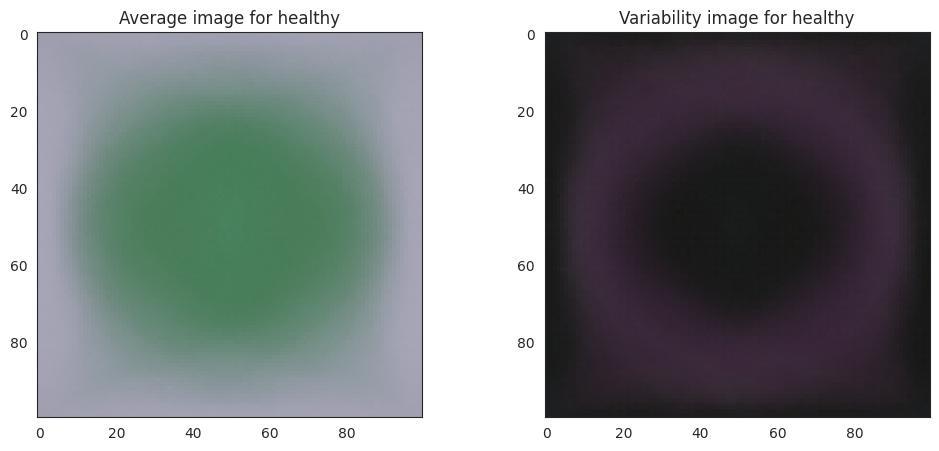

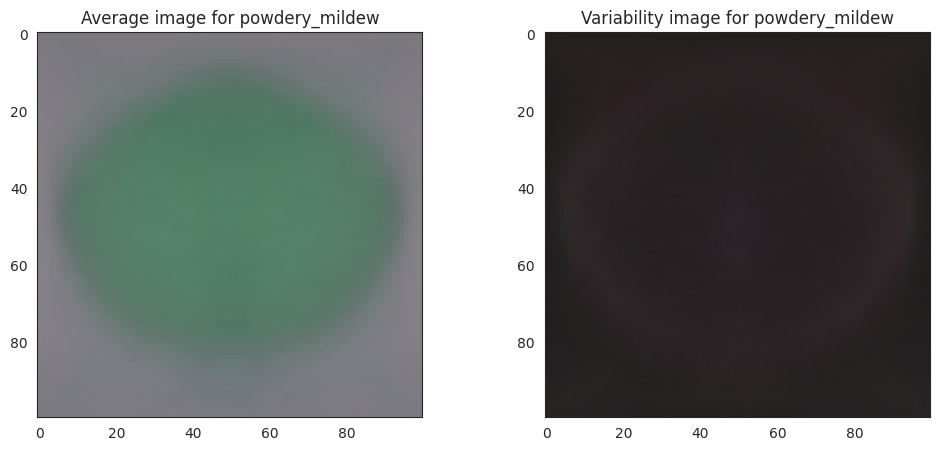

In [15]:
# Code borrowed from Walkthrough project 1
# Use X_train and y_train as variables
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, file_path="."):
    """
    Plot mean and variability of images per label.
    
    Parameters:
        X (numpy.ndarray): Array of images.
        y (numpy.ndarray): Array of corresponding labels.
        figsize (tuple): Size of the figure.
        save_image (bool): Whether to save the image or not.
        file_path (str): Path to save the images.
    """
    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

plot_mean_variability_per_labels(X_train, y_train, figsize=(12, 5), save_image=True)

## Difference between average healthy and powdery mildew images

label1_avg: min=0.3025791645050049, max=0.5323477983474731, mean=0.4486374855041504
label2_avg: min=0.27665719389915466, max=0.7230957746505737, mean=0.5289922952651978
difference_mean: min=-0.2177833616733551, max=0.07140064239501953, mean=-0.08035478740930557


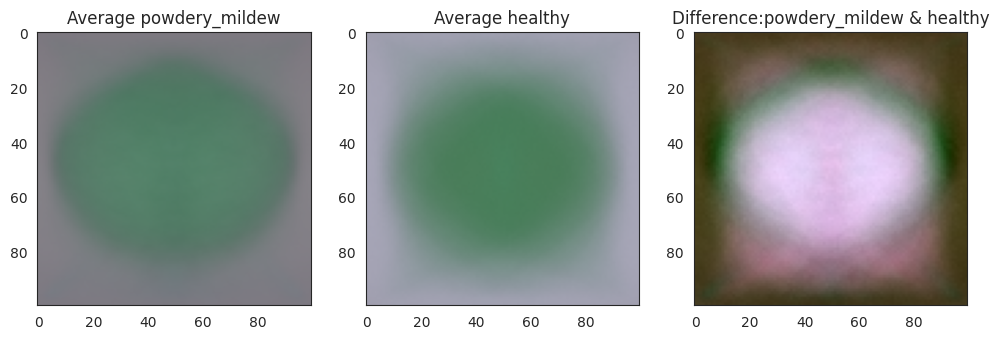

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the subset_image_label function
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False, file_path='.'):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} are not in {np.unique(y)} ")
        return

    # Calculate mean from label1
    images_label1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label1, axis=0)

    # Calculate mean from label2
    images_label2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label2, axis=0)

    # Calculate difference
    difference_mean = label1_avg - label2_avg

    # Debugging: Print the min, max, and mean values of the average images and their difference
    print(f"label1_avg: min={np.min(label1_avg)}, max={np.max(label1_avg)}, mean={np.mean(label1_avg)}")
    print(f"label2_avg: min={np.min(label2_avg)}, max={np.max(label2_avg)}, mean={np.mean(label2_avg)}")
    print(f"difference_mean: min={np.min(difference_mean)}, max={np.max(difference_mean)}, mean={np.mean(difference_mean)}")

    # Normalize the difference image for better visualization
    difference_mean_norm = (difference_mean - np.min(difference_mean)) / (np.max(difference_mean) - np.min(difference_mean))

    # Plot difference, avg label1, and avg label2
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    im = axes[2].imshow(difference_mean_norm, cmap='RdBu')
    axes[2].set_title(f'Difference:{label_1} & {label_2}')

    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()
        
diff_bet_avg_image_labels_data_as_array(X_train, y_train,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True,
                                        file_path='/workspace/mildew-detection/outputs')

## Image montage

Using X_train and y_train as variables, because these arrays already contain the resized image size. This ensures that the montage function works with the preprocessed, smaller images.

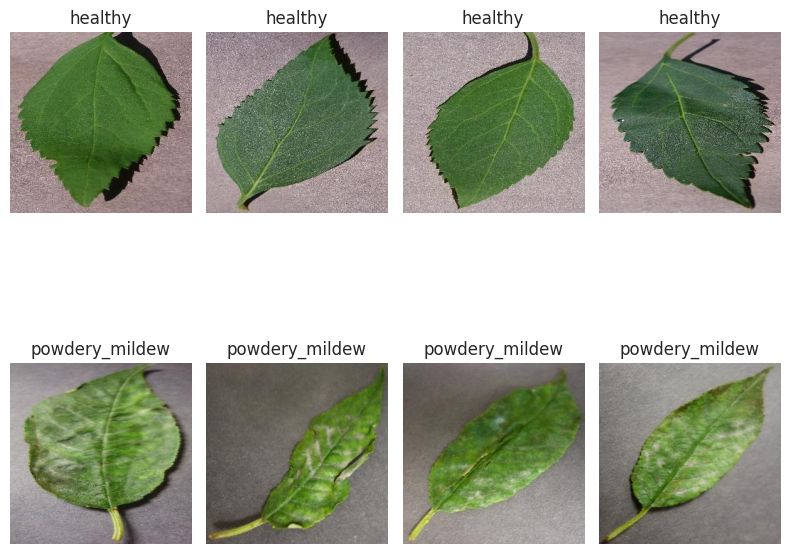

In [32]:
# Parts of code borrowed from linx02 - genderpredictor 
import matplotlib.pyplot as plt
import pandas as pd

# Image montage / Sample of dataset
sample_size = 8  # Total number of images

healthy_df = train_df[train_df['label'] == 'healthy']
powdery_mildew_df = train_df[train_df['label'] == 'powdery_mildew']

sample_healthy = healthy_df.sample(n=round(sample_size / 2))
sample_powdery_mildew = powdery_mildew_df.sample(n=round(sample_size / 2))

sample = pd.concat([sample_healthy, sample_powdery_mildew])

cols = 4  # Number of columns in the montage
rows = (sample_size + cols - 1) // cols  # Calculate the number of rows

fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

for i, image_path in enumerate(sample['file']):
    ax = axes[i // cols, i % cols]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title(sample.iloc[i]['label'])  
    ax.axis('off')

# Remove any empty subplots
for i in range(sample_size, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

---